# Video Classification (Humpback Whales) - Keras CNN + RNN 

Source: https://keras.io/examples/vision/video_classification/


Description: Following the tutorial above to try and configure cnn + rnn combined architecture to classify youtube videos as containing a humpback whale encounter (True / relevant) or not (False / irrelevant)

Modifications (how v3 differs from v2):
- Instead of padding videos with last available frame, pad with frame from middle of frames available
- possibly implement data augmentation

# Setup

In [2]:
# !pip install -q git+https://github.com/tensorflow/docs

In [170]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import pickle
import glob
import cv2
import os

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

# Define Hyperparameters

In [6]:
#need to find out what each hyperparameter is for
# [TO DO]
ROOT_DIR = os.path.dirname(os.path.abspath('video_classification_cnn_rnn_v2.ipynb'))

IMG_SIZE = 224
BATCH_SIZE = 64 
EPOCHS = 10 

MAX_SEQ_LENGTH = 31 #480 #31 #max frames per video (even if multiple clips)
NUM_FEATURES = 2048 #the number of features we extract from frames using InceptionV3 (kepts same as tutorial)

print(f"MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")

MAX_SEQ_LENGTH: 31


# Data Preparation

### Load Video (Original)

In [552]:
## Get frames from a video in array format
def load_video(path, max_frames, resize=(IMG_SIZE, IMG_SIZE)):
    ''' returns array representation of image frames from video passed in'''
    
    delay = 0.5
    count = 0
    num_frames = 0

    cap = cv2.VideoCapture(path)
    frames = []
    
    # print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    try:
        while True and num_frames < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  #opencv fives BGR [0,1,2] channel order; this line of code reorders our color channels to RGB [2,1,0]
            frames.append(frame)

            #to skip over some redundant frames and get more diverse set of frames over span of our video
            #while still getting a fixed, uniform number of max_frames for each video
            
            count += delay * fps
            cap.set(1, count)

            num_frames += 1

    finally:
        cap.release()

    return np.array(frames)


## use a pre-trained network to extract meaningful features from the extracted frames
## Here, we use InceptionV3 (same as tutorial), which is pre-trained on the ImageNet-1k dataset
def build_feature_extractor():
    '''Extracts meaningful features from frames using InceptionV3, which is pre-trained on ImageNet-1k dataset'''

    #instantiate InceptionV3 as feature extractor (don't include top layer bc we're not using this for classification - just feature extraction)
    feature_extractor = keras.applications.InceptionV3(
                                                        weights      = 'imagenet',
                                                        include_top  = False,
                                                        pooling      = 'avg',
                                                        input_shape  = (IMG_SIZE, IMG_SIZE, 3)
                                                    )


    #required preprocessing for inceptionV3 - scales input pixels between -1 and 1
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")



### Testing out load_video()

In [77]:
MAX_SEQ_LENGTH

31

In [78]:
## trying out load_video on an example_vid (this function gets 31 (max_frames) frames per video)
## NOTE: when dealing with multiple clips from one video, will have to set max_frames = 31/num_clips_from_video

# example_vid = 'video_clips/video_0119_clip_0.mp4'
# example_vid = 'video_clips/video_0000_clip_1.mp4'
# example_vid = 'video_clips/video_0041_clip_0.mp4'
example_vid = 'video_clips/video_0001_clip_0.mp4'

frames = load_video(example_vid, max_frames=MAX_SEQ_LENGTH)

print(frames.shape) 

(20, 224, 224, 3)


### Feature Extractor

In [553]:
## using feature_extractor to extract meaningful features from frames
feature_extractor = build_feature_extractor()
feature_extractor

### Encode labels (relevant) to numerical form before feeding them to the model

In [71]:
# encode relevant true/false labels as integers: true as 1, false as 0
def label_processor(labels_column):
    return labels_column.astype(int)

### Putting all the pieces together (load_video, preprocessing input, converting labels to int) to create our data processing utility

In [86]:
def prepare_all_videos(X, y, clip_folder, root_dir):
    num_samples = len(X)
    video_names = X["renamed_title"].values.tolist()
    labels      = y['relevant'].values 
    labels      = label_processor(labels[..., None])

    # `frame masks` and `frame_features are what we will feed to our sequence model
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is masked 
    #  with padding or not
    frame_masks    = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros( shape = (num_samples, MAX_SEQ_LENGTH, NUM_FEATURES) , dtype="float32")

    #for each video
    for index, video_name in enumerate(video_names):
        
        #Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
        video_name = video_name.split('.mp4')[0]
        frames     = get_frames_for_all_clips(video_name, clip_folder, root_dir)

        #initialize placeholders to store the masks and features of the current video
        temp_frame_mask     = np.zeros(shape=(1, MAX_SEQ_LENGTH ), dtype="bool")  
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        #extract features from the frames of the current video
        for i, batch in enumerate(frames):
            
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            
            temp_frame_mask[i, :length] = 1 # 1 = not masked, 0 = masked

        frame_features[index, ] = temp_frame_features.squeeze()
        frame_masks[index, ]    = temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels


def get_frames_for_all_clips(video, clip_folder, root_dir):

    '''
    gets the frames across all clips belonging to a video
    
    first:      find all clips belonging to video
    then:       get 40/n_clips frames from each clip (put them all in same frames array)
    finally:    add batch dimension 
    '''
    print(video)

    # find all clips from the same video
    video_clips = sorted([clip for clip in glob.glob(clip_folder + video + '*.mp4')])

    #get frames for each clip belonging to video and append to frames array
    #set max_frames_per_clip so we get MAX_SEQ_LENGTH (40) total frames for each video
    max_frames_per_clip = MAX_SEQ_LENGTH / len(video_clips)
    frames              = load_video(os.path.join(root_dir, video_clips[0]), max_frames = max_frames_per_clip)
    
    for clip_path in video_clips[1:]:
        clip_frames = load_video(os.path.join(root_dir, clip_path), max_frames = max_frames_per_clip)
        frames      = np.concatenate((frames, clip_frames))
    
    print('frames.shape: ', frames.shape)
    # add batch dimension
    return frames[None, ...]


## Preparing train and test features, masks, and labels arrays

In [89]:
# train_data, train_labels = prepare_all_videos(X_train, y_train, 'video_clips/', ROOT_DIR)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


Frame features in train set: (325, 31, 2048)
Frame masks in train set: (325, 31)


In [94]:
# test_data, test_labels   = prepare_all_videos(X_test, y_test, 'video_clips/', ROOT_DIR)

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in test set: (82, 31, 2048)
Frame masks in test set: (82, 31)


In [366]:
## getting features, masks, and labels for unsplit full data (X, y)
# all_data, all_labels    = prepare_all_videos(X, y, 'video_clips/', ROOT_DIR)

print(f"ALL Frame features: {all_data[0].shape}")
print(f"ALL Frame masks:    {all_data[1].shape}")
print(f"ALL Frame labels:   {all_labels.shape}")


ALL Frame features: (407, 31, 2048)
ALL Frame masks:    (407, 31)
ALL Frame labels:   (407, 1)


## Saving Frame Features, Masks, and Labels Arrays Locally

In [367]:
## saving frame features, masks, and labels ndarrays to numpy files
## source: https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

# np.savez_compressed('data_v2/train_frame_features.npz', train_data[0])
# np.savez_compressed('data_v2/train_frame_masks.npz', train_data[1])
# np.savez_compressed('data_v2/train_labels.npz', train_labels)

# print('done saving train features, masks, and labels ...')

# np.savez_compressed('data_v2/test_frame_features.npz', test_data[0])
# np.savez_compressed('data_v2/test_frame_masks.npz', test_data[1])
# np.savez_compressed('data_v2/test_labels.npz', test_labels)

# print('done saving test features, masks, and labels ...')

np.savez_compressed('data_v2/all_frame_features.npz', all_data[0])
np.savez_compressed('data_v2/all_frame_masks.npz', all_data[1])
np.savez_compressed('data_v2/all_labels.npz', all_labels)

print('done saving all features, masks, and labels ...')

done saving all features, masks, and labels ...


## Reloading Saved Frame Features, Masks, and Labels

In [11]:
## loading numpy arrays from npz files

train_frame_features      = np.load('data_v2/train_frame_features.npz')['arr_0']
train_frame_masks         = np.load('data_v2/train_frame_masks.npz')['arr_0']
train_labels              = np.load('data_v2/train_labels.npz')['arr_0']

test_frame_features       = np.load('data_v2/test_frame_features.npz')['arr_0']
test_frame_masks          = np.load('data_v2/test_frame_masks.npz')['arr_0']
test_labels               = np.load('data_v2/test_labels.npz')['arr_0']

all_frame_features        = np.load('data_v2/all_frame_features.npz')['arr_0']
all_frame_masks           = np.load('data_v2/all_frame_masks.npz')['arr_0']
all_labels                = np.load('data_v2/all_labels.npz')['arr_0']

# to reload our filled frame features, masks, and labels for unsplit dataset
all_frame_features_filled = np.load('data_v2/all_frame_features_filled.npz')['arr_0']
all_frame_masks_filled    = np.load('data_v2/all_frame_masks_filled.npz')['arr_0']
all_labels_filled         = np.load('data_v2/all_labels_filled.npz')['arr_0']

In [17]:
print('train frame features: ', train_frame_features.shape)
print('train frame masks:    ', train_frame_masks.shape)
print('train labels:         ', train_labels.shape)
print('\n')

print('test frame features: ', test_frame_features.shape)
print('test frame masks:    ', test_frame_masks.shape)
print('test labels:         ', test_labels.shape)
print('\n')

print('all frame features:  ', all_frame_features.shape)
print('all frame masks:     ', all_frame_masks.shape)
print('all labels:          ', all_labels.shape)
print('\n')

print(f"ALL Frame features filled: {all_frame_features_filled.shape}")
print(f"ALL Frame masks filled:    {all_frame_masks_filled.shape}")
print(f"ALL Frame labels filled:   {all_labels_filled.shape}")

train frame features:  (325, 31, 2048)
train frame masks:     (325, 31)
train labels:          (325, 1)


test frame features:  (82, 31, 2048)
test frame masks:     (82, 31)
test labels:          (82, 1)


all frame features:   (407, 31, 2048)
all frame masks:      (407, 31)
all labels:           (407, 1)


ALL Frame features filled: (407, 31, 2048)
ALL Frame masks filled:    (407, 31)
ALL Frame labels filled:   (407, 1)


## Checking how many frames have empty masks in our saved train/test arrays

Total Number of Train videos with empty frames: 88


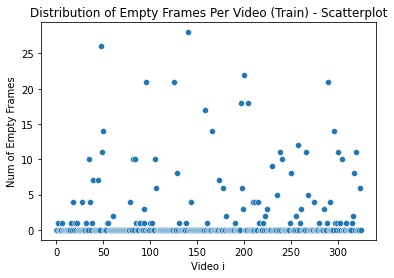

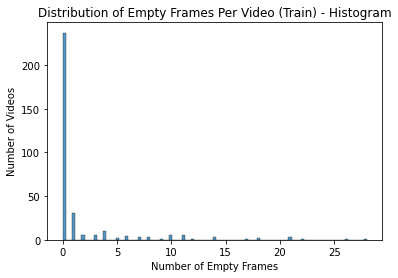

In [19]:
video_empty_frame_counts = []
for i in range(0, 325):
    num_empty = len(train_frame_masks[i][train_frame_masks[i] == False])
    video_empty_frame_counts.append(num_empty)

print(f'Total Number of Train videos with empty frames: {sum(x > 0 for x in video_empty_frame_counts)}')

#Distribution of Empty frames Per Video - Scatterplot
fig, ax = plt.subplots(figsize=(6,4));
ax = sns.scatterplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video (Train) - Scatterplot', xlabel = 'Video i', ylabel = 'Num of Empty Frames');

#Distribution of Empty frames Per Video - Histogram
fig, ax = plt.subplots(figsize=(6,4));
ax = sns.histplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video (Train) - Histogram', xlabel = 'Number of Empty Frames', ylabel = 'Number of Videos');


Observations: 
- Most videos have 0 empty frames, meaning most of our videos `don't` have empty frames, but there are still a couple train videos (88, to be exact) with empty frames. 
- The number of empty frames spans from 1 to 28 (max numbr of empty frames in train set). For our train set, we would have at most replicate a frame (ex. the last frame) 28 times

Since the max number of frames that we would need to replicate is 28, our padding strategy will start out as just replicating the last frame in order to reach our MAX_FRAMES count. The reasoning behind this is that since we would need to replicate at most 28 frames for any particular video, this means that the lowest number of actual frames we have to represent a video is 3, so the last frame is most likely similar to the other 2 (short clip), reducing our potential bias of video segment overrepresentation. 

## Padding (Attempt #1 - Pad with Last Frame of Videos)

Padding:
1. Check if the Video Needs Padding
2. If the video needs padding, replicate the last frame until MAX_FRAMES is reached

In [412]:
## Get all the features, frames, and labels for each video across our ENTIRE dataset (no train/test splits)
## then do the replication on this data so we have it handy for our new cross validation application

# all_frame_features_filled = all_frame_features.copy()
# all_frame_masks_filled    = all_frame_masks.copy()
# all_labels_filled         = all_labels.copy()

# print(f"ALL Frame features: {all_frame_features_filled.shape}")
# print(f"ALL Frame masks:    {all_frame_masks_filled.shape}")
# print(f"ALL Frame labels:   {all_labels_filled.shape}")

In [400]:
# ## Replicate the last frame for all videos with empty frames in our unsplit dataset

# for video_i in range(0, len(all_frame_masks_filled)):

#     ## get empty frame indices + actual frame indices
#     empty_frame_indices = [i for i,v in enumerate(all_frame_masks_filled[video_i]) if v == False]

#     ## check if we have empty frames + proceed to fill in if we do
#     if len(empty_frame_indices) > 0:

#         ## this is the index of the frame we want to replicate for len(empty_frame_indices) times
#         last_index_with_non_empty_frame = empty_frame_indices[0] - 1 

#         ## get the features of the last non empty frame (this is what we will replicate)
#         last_non_empty_frame = all_frame_features_filled[video_i][last_index_with_non_empty_frame]

#         #fill in the empty_frame_indices in all_frame_features_filled with the last_non_empty_frame
#         for empty_index in empty_frame_indices:
#             all_frame_features_filled[video_i][empty_index] = last_non_empty_frame
#             all_frame_masks_filled[video_i][empty_index]    = True


# print('done filling frames for unsplit dataset...')


done filling frames for unsplit dataset...


Total Number of videos with empty frames: 0


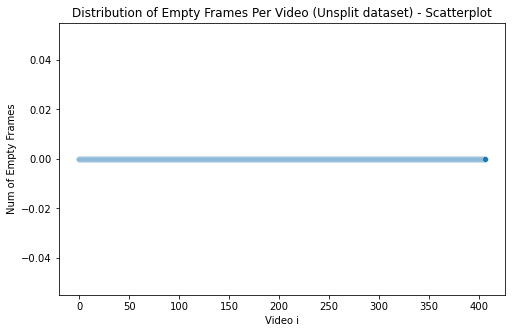

In [20]:
## plot number of empty frames to double check (all empty frame counts are 0 - we are good to go!)
video_empty_frame_counts = []
for i in range(0, 407):
    num_empty = len(all_frame_masks_filled[i][all_frame_masks_filled[i] == False])
    video_empty_frame_counts.append(num_empty)

print(f'Total Number of videos with empty frames: {sum(x > 0 for x in video_empty_frame_counts)}')

#Distribution of Empty frames Per Video - Scatterplot
fig, ax = plt.subplots(figsize=(8,5));
ax = sns.scatterplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video (Unsplit dataset) - Scatterplot', xlabel = 'Video i', ylabel = 'Num of Empty Frames');


## Padding (Attempt #2 - Pad with Frame at Middle of Videos)

Padding:
1. Check if the Video Needs Padding
2. If the video needs padding, replicate the middle frame until MAX_FRAMES is reached

In [146]:
# ## Get all the features, frames, and labels for each video across our ENTIRE dataset (no train/test splits)
# ## then do the replication on this data 

# all_frame_features_filled_middle = all_frame_features.copy()
# all_frame_masks_filled_middle    = all_frame_masks.copy()
# all_labels_filled_middle         = all_labels.copy()

# print(f"ALL Frame features middle: {all_frame_features_filled_middle.shape}")
# print(f"ALL Frame masks middle:    {all_frame_masks_filled_middle.shape}")
# print(f"ALL Frame labels middle:   {all_labels_filled_middle.shape}")

ALL Frame features middle: (407, 31, 2048)
ALL Frame masks middle:    (407, 31)
ALL Frame labels middle:   (407, 1)


Total Number of Train videos with empty frames: 105


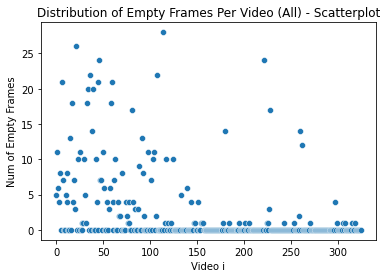

In [148]:
##before filling in empty frames with replicated middle frame
video_empty_frame_counts = []
for i in range(0, 325):
    num_empty = len(all_frame_masks_filled_middle[i][all_frame_masks_filled_middle[i] == False])
    video_empty_frame_counts.append(num_empty)

print(f'Total Number of Train videos with empty frames: {sum(x > 0 for x in video_empty_frame_counts)}')

#Distribution of Empty frames Per Video - Scatterplot
fig, ax = plt.subplots(figsize=(6,4));
ax = sns.scatterplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video (All) - Scatterplot', xlabel = 'Video i', ylabel = 'Num of Empty Frames');


In [149]:
# REPLICATE MIDDLE FRAME + INSERT IN ORDER SO WE HAVE NO EMPTY FRAMES
for video_i in range(0, len(all_frame_features_filled_middle)):
    #get masks and features belonging to video
    masks    = all_frame_masks_filled_middle[video_i]
    features = all_frame_features_filled_middle[video_i]

    #get indices of empty frames, actual frames, and all
    empty_frame_indices  = [i for i,v in enumerate(masks) if v == False]
    actual_frame_indices = [i for i,v in enumerate(masks) if v == True]

    #get index of middle frame, and the middle feature frame itself
    middle_frame_to_replicate_index = actual_frame_indices[len(actual_frame_indices) // 2]
    middle_frame_to_replicate       = features[middle_frame_to_replicate_index].copy()

    #get indices from second half and the features at those indices 
    #we will move the 2nd half to the end of the array, after replicating the middle frame
    second_half_start     = middle_frame_to_replicate_index + 1
    second_half_end       = actual_frame_indices[-1]
    second_half_features  = features[second_half_start: second_half_end + 1].copy()

    #replicate frame at mid index
    offset = middle_frame_to_replicate_index
    for i in range(1, len(empty_frame_indices) + 1):
        all_frame_features_filled_middle[video_i][i + offset] = middle_frame_to_replicate
        all_frame_masks_filled_middle[video_i][i + offset]    = True

    #now add in second half at end of features array (BACKWARDS)
    for i in range(1, len(second_half_features) + 1):
        all_frame_features_filled_middle[video_i][-i] = second_half_features[-i]
        all_frame_masks_filled_middle[video_i][-i]    = True

print('Done replacing empty frames with replicated middle frame ...')


Done replacing empty frames with replicated middle frame ...


Total Number of videos with empty frames: 0


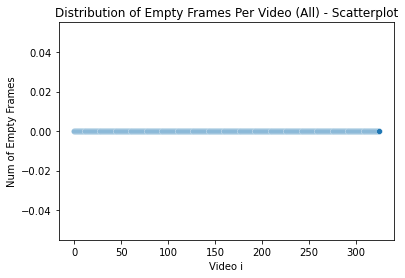

In [154]:
## after filling in empty frames with middle replicated frame while keeping frame order
video_empty_frame_counts = []
for i in range(0, 325):
    num_empty = len(all_frame_masks_filled_middle[i][all_frame_masks_filled_middle[i] == False])
    video_empty_frame_counts.append(num_empty)

print(f'Total Number of videos with empty frames: {sum(x > 0 for x in video_empty_frame_counts)}')

#Distribution of Empty frames Per Video - Scatterplot
fig, ax = plt.subplots(figsize=(6,4));
ax = sns.scatterplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video (All) - Scatterplot', xlabel = 'Video i', ylabel = 'Num of Empty Frames');


In [151]:
# #save the new features, masks, and labels
# np.savez_compressed('data_v2/all_frame_features_filled_middle.npz', all_frame_features_filled_middle)
# np.savez_compressed('data_v2/all_frame_masks_filled_middle.npz', all_frame_masks_filled_middle)
# np.savez_compressed('data_v2/all_labels_filled_middle.npz', all_labels_filled_middle)

print('done saving all filled middle features, masks, and labels ...')

done saving all filled middle features, masks, and labels ...


In [153]:
# to reload our filled middle frame features, masks, and labels for unsplit dataset
all_frame_features_filled = np.load('data_v2/all_frame_features_filled_middle.npz')['arr_0']
all_frame_masks_filled    = np.load('data_v2/all_frame_masks_filled_middle.npz')['arr_0']
all_labels_filled         = np.load('data_v2/all_labels_filled_middle.npz')['arr_0']

print(f"ALL Frame features filled middle: {all_frame_features_filled_middle.shape}")
print(f"ALL Frame masks filled middle:    {all_frame_masks_filled_middle.shape}")
print(f"ALL Frame labels filled middle:   {all_labels_filled_middle.shape}")

ALL Frame features filled middle: (407, 31, 2048)
ALL Frame masks filled middle:    (407, 31)
ALL Frame labels filled middle:   (407, 1)


# The Sequence Model

Now, we can feed this data to a sequence model consisting of recurrent layers like GRU


### Fitting Model with Cross Validation

FIXME: should not use test set during cross validation (only train!!).
Test set should only be fed in one time, after we have decided on the best model to use

EDIT: we should actually be using cross validation to find what the best accuracy for our model is based on our entire data; this way, ever example has a chance to be part of the test set AND train set at some point

In [156]:
def get_model_name(k):
    return 'model_'+ k +'.h5'

def load_dataset(X_path, y_path):
    '''
    loads in datasets: note for data_v2 train and test, we get rid of unordered (orig) index
    and instead keep and ordered index 0...len(X) 
    
    This is what we want so that the indices in X,y match with our train/test frame feature and masks
    '''
    X = pd.read_csv(X_path)
    y = pd.read_csv(y_path)                       

    X.drop(columns=['Unnamed: 0'], inplace = True)  #since we stored our labels in y
    y.drop(columns=['Unnamed: 0'], inplace = True)
    
    print(X.shape)
    print(y.shape)

    return X, y

def load_unsplit_dataset(unsplit_csv):
    X       = pd.read_csv(unsplit_csv) 
    y       = X['relevant'].to_frame()
    X       = X.drop(columns=['relevant', 'Unnamed: 0'])

    return X, y

### The following model uses our features, masks, and labels where we replicated the MIDDLE frame to avoid using empty frames
- note that we keep the order of the video frames even when replicating the middle frame
- essentially the features are now something like: 0,1,2,2,2,2,2,3,4 where 2 is the "middle" frame

In [157]:
#where to store our models 
save_dir = 'saved_models_v3/'

#define the Stratified K-fold Cross Validator (use strat for equal num of class examples in folds)
fold_no   = 1
num_folds = 5
skfold    = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)

# Store Test Acc and Loss for K-fold Cross Validation model evaluation
test_acc_per_fold       = dict()
test_loss_per_fold      = dict()
histories_per_fold      = dict()
fold_train_test_indices = dict() #{'fold_model_name': [fold_train_index_list, fold_test_index_list]}

# Load in unsplit X and y (from data_v2) + reindex so our indices match with our save features, masks, labels arrays
X, y = load_unsplit_dataset('humpback_whale_videos_with_intervals.csv')

for train_index, test_index in skfold.split(X, y):

    print('------------------------------------------------------------------------')
    print(f"Fold {fold_no}...")

    #get frame features and masks of train folds
    train_features_fold, train_masks_fold, train_labels_fold = all_frame_features_filled_middle[train_index], all_frame_masks_filled_middle[train_index], all_labels_filled_middle[train_index]
    test_features_fold,  test_masks_fold,  test_labels_fold  = all_frame_features_filled_middle[test_index],  all_frame_masks_filled_middle[test_index],  all_labels_filled_middle[test_index]

    #create + compile the model
    class_vocab          = [0, 1] 
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input           = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")

    x                    = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x                    = keras.layers.GRU(8)(x)
    x                    = keras.layers.Dropout(0.4)(x)
    x                    = keras.layers.Dense(8, activation="relu")(x)
    output               = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model            = keras.Model([frame_features_input, mask_input], output)
    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) #ok to use sparse_categorical_crossentropy as long as we have 2 or more label classes

    #Fit data to model
    #my_callbacks only saves best weights (when best val_loss is achieved)
    fold_model_name = get_model_name(str(fold_no) + '_cv')
    filepath        = save_dir + fold_model_name
    my_callbacks    = [keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=0)]

    #Generate a print
    print(f'Training for fold {fold_no} ...')
    history = rnn_model.fit(   [train_features_fold, train_masks_fold], 
                               train_labels_fold,
                               validation_split = 0.1,
                               callbacks = my_callbacks,
                               epochs = 10,
                               verbose= 0
                            )


    # Generate metrics on validation data
    test_loss, test_accuracy = rnn_model.evaluate([test_features_fold, test_masks_fold], test_labels_fold)

    print(f'TEST Metrics for Fold {fold_no}: Accuracy = {test_accuracy}     Loss = {test_loss}')

    #store the test accuracies and loss for each fold model
    test_acc_per_fold[fold_model_name]       = test_accuracy
    test_loss_per_fold[fold_model_name]      = test_loss
    histories_per_fold[fold_model_name]      = history
    fold_train_test_indices[fold_model_name] = [train_index, test_index]
    
    print('------------------------------------------------------------------------')

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Fold 1...


2022-03-12 15:16:14.440726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training for fold 1 ...
3/3 [==============================] - 0s 10ms/step - loss: 0.3477 - accuracy: 0.8902
TEST Metrics for Fold 1: Accuracy = 0.8902438879013062     Loss = 0.34774914383888245
------------------------------------------------------------------------
------------------------------------------------------------------------
Fold 2...
Training for fold 2 ...
3/3 [==============================] - 0s 10ms/step - loss: 0.2861 - accuracy: 0.8659
TEST Metrics for Fold 2: Accuracy = 0.8658536672592163     Loss = 0.2861340343952179
------------------------------------------------------------------------
------------------------------------------------------------------------
Fold 3...
Training for fold 3 ...
3/3 [==============================] - 0s 10ms/step - loss: 0.3849 - accuracy: 0.8519
TEST Metrics for Fold 3: Accuracy = 0.8518518805503845     Loss = 0.3848790228366852
------------------------------------------------------------------------
-----------------------------

In [158]:
test_acc_per_fold

{'model_1_cv.h5': 0.8902438879013062,
 'model_2_cv.h5': 0.8658536672592163,
 'model_3_cv.h5': 0.8518518805503845,
 'model_4_cv.h5': 0.8395061492919922,
 'model_5_cv.h5': 0.8024691343307495}

In [159]:
test_loss_per_fold

{'model_1_cv.h5': 0.34774914383888245,
 'model_2_cv.h5': 0.2861340343952179,
 'model_3_cv.h5': 0.3848790228366852,
 'model_4_cv.h5': 0.40652135014533997,
 'model_5_cv.h5': 0.4183914363384247}

In [160]:
histories_per_fold

{'model_1_cv.h5': <keras.callbacks.History at 0x18c6bbfa0>,
 'model_2_cv.h5': <keras.callbacks.History at 0x18e0cce50>,
 'model_3_cv.h5': <keras.callbacks.History at 0x18f441910>,
 'model_4_cv.h5': <keras.callbacks.History at 0x1907bdc70>,
 'model_5_cv.h5': <keras.callbacks.History at 0x191b29e20>}

In [161]:
fold_train_test_indices #structure: {'model name': [[fold_train_indices], [fold_test_indices]], 'model name 2': [...], ...}

{'model_1_cv.h5': [array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  17,  18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  30,
          31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  45,
          46,  47,  50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  61,
          62,  63,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          79,  80,  81,  83,  84,  85,  86,  87,  88,  90,  91,  93,  94,
          97,  98, 100, 102, 103, 105, 107, 108, 109, 110, 111, 112, 113,
         114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129,
         130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145,
         146, 147, 149, 151, 155, 158, 160, 162, 163, 164, 165, 167, 168,
         170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 182, 183, 184,
         185, 186, 187, 188, 191, 192, 194, 195, 196, 197, 198, 199, 201,
         202, 203, 204, 205, 206, 210, 211, 212, 213, 214, 216, 217, 218,
         219, 220, 22

In [171]:
#save dictionary of fold indices
with open('saved_models_v3/fold_indices.pkl', 'wb') as f:
    pickle.dump(fold_train_test_indices, f)
print('Done saving dictionary of fold train test indices')


Done saving dictionary of fold train test indices


In [174]:
cross_val_avg_accuracy = np.mean(list(test_acc_per_fold.values()))
cross_val_avg_loss     = np.mean(list(test_loss_per_fold.values()))

print(f"Average Accuracy with 5-fold Cross Validation: {cross_val_avg_accuracy}")
print(f"Average Loss with 5-fold Cross Validation:     {cross_val_avg_loss}")

Average Accuracy with 5-fold Cross Validation: 0.8499849438667297
Average Loss with 5-fold Cross Validation:     0.36873499751091005


## `Note`: we don't have an `actual` model that gives us the 84% accuracy

# Inference

In [202]:
def prepare_single_video(frames):
    frame_mask     = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i,j,:] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1 #1 = not masked, 0 = masked

    return frame_features, frame_mask

#generates prediction and accuracy scores for a single video with model passed in
def sequence_prediction(path, model, silent=False):
    class_vocab = [0, 1] #label_processor.get_vocabulary()

    # Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
    path   = path.split('.mp4')[0]
    frames = get_frames_for_all_clips(path, "video_clips/", ROOT_DIR)
    
    frame_features, frame_mask = prepare_single_video(frames)
    
    probabilities = model.predict([frame_features, frame_mask])[0]

    if silent == False:
        for i in np.argsort(probabilities)[::-1]:
            print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    return frames, probabilities

# This utility is for visualization. Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images, video_name, saveto_path):
    
    converted_images = images.astype(np.uint8)
    imageio.mimsave(f"{saveto_path}{video_name}.gif", converted_images, fps=10)
    return embed.embed_file(f"{saveto_path}{video_name}.gif")


In [ ]:
# classes = ['nonrelevant', 'relevant']

# #get max probability class for each row 
# for i in range(0, len(probabilities)):
#     video_predicted_class_probabilities = probabilities[i]

#     greatest_to_least_class     = np.argsort(video_predicted_class_probabilities)[::-1] #this returns the class labels in order of greatest probability to least probability predicted
#     predicted_class             = greatest_to_least_class[0] #the most confident class prediction is first (index 0)
#     predicted_class_probability = video_predicted_class_probabilities[predicted_class] #the actual probability of most confident class

#     print(video_predicted_class_probabilities)
#     print(f"{predicted_class} ({classes[predicted_class]}): {predicted_class_probability * 100:5.2f} %")
#     print('---------------')


## Inference on 5 test folds 
Getting accuracy, loss, confusion matrix, precision, recall, and f1 metrics for each model, then calculating the average

In [259]:
#step 1: load in our 5 models generated at each fold from saved_models_v3
def create_rnn_model():
    class_vocab          = [0, 1] 
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input           = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")

    x                    = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x                    = keras.layers.GRU(8)(x)
    x                    = keras.layers.Dropout(0.4)(x)
    x                    = keras.layers.Dense(8, activation="relu")(x)
    output               = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    return keras.Model([frame_features_input, mask_input], output)

#step 2: load in train/test indices at each fold
#structure: {'model name': [[fold_train_indices], [fold_test_indices]], 'model name 2': [...], ...}
def load_fold_indices():
    with open('saved_models_v3/fold_indices.pkl', 'rb') as f:
        fold_indices = pickle.load(f)
    
    return fold_indices 

### Define Model Version (For Saving Figures)

In [260]:
model_version = 'v3'

### Load in Fold Models + Get Metrics for each one

In [265]:
#load in saved fold_indices from kfold split from training
fold_indices = load_fold_indices()

#arrays to store each models metrics
#we already have test_acc_per_fold, test_loss_per_fold, and histories_per_fold (dict)
accuracy_per_fold = []
confusion_matrix_per_fold = []
precision_per_fold = []
recall_per_fold    = []
f1_per_fold        = []

for fold_no in range(1, 6):

    #get fold model name and path to weights
    fold_model_name = get_model_name(str(fold_no) + '_cv')
    weights_path    = 'saved_models_v3/' + fold_model_name

    #create rnn model and load weights 
    fold_rnn_model = create_rnn_model()
    fold_rnn_model.load_weights(weights_path) #load in weights

    #get test data for fold
    test_index = fold_indices[fold_model_name][1]
    test_features_fold,  test_masks_fold,  test_labels_fold  = all_frame_features_filled_middle[test_index],  all_frame_masks_filled_middle[test_index],  all_labels_filled_middle[test_index]

    #compile
    fold_rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) 

    #predict
    probabilities = fold_rnn_model.predict([test_features_fold, test_masks_fold])
    y_pred = np.array([np.argmax(p) for p in probabilities])
    y_true = test_labels_fold.flatten()

    #metrics for FOLD MODEL
    fold_test_acc = metrics.accuracy_score(y_true, y_pred)
    print(f'Test Accuracy for fold_no={fold_no}: {fold_test_acc}')

    cm = metrics.confusion_matrix(y_true, y_pred)
    precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred) #precision, recall, f1, and support are obtained for each class [0 1] (ex. precision = [0.92  0.86])

    #save metrics for each fold model
    accuracy_per_fold.append(fold_test_acc)
    confusion_matrix_per_fold.append(cm)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

Test Accuracy for fold_no=1: 0.8902439024390244
Test Accuracy for fold_no=2: 0.8780487804878049
Test Accuracy for fold_no=3: 0.8641975308641975
Test Accuracy for fold_no=4: 0.8395061728395061
Test Accuracy for fold_no=5: 0.8148148148148148


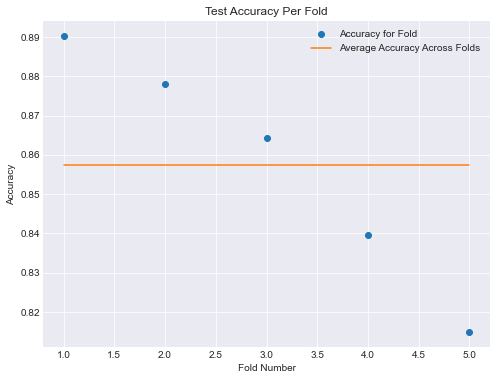

In [404]:
plt.figure(figsize=(8,6))
plt.plot([i for i in range(1,6)], accuracy_per_fold, 'o');
plt.plot([i for i in range(1,6)], [np.mean(accuracy_per_fold) for i in range(1,6)]);
plt.title('Test Accuracy Per Fold');
plt.xlabel('Fold Number');
plt.ylabel('Accuracy');
plt.legend(labels = ['Accuracy for Fold', 'Average Accuracy Across Folds'], loc = 'upper right');

In [268]:
#average accuracy on test set (rerun on saved weights)
print('Average Test Accuracy for 5-fold Cross Validation: ', np.mean(accuracy_per_fold))

Average Test Accuracy for 5-fold Cross Validation:  0.8573622402890695


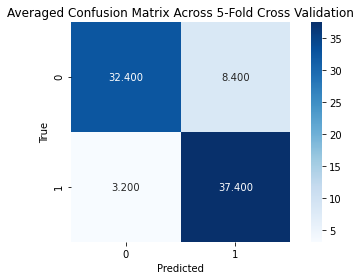

In [302]:
#averaged confusion matrix across 5-folds
avg_TN = np.sum([cm[0][0] for cm in confusion_matrix_per_fold]) / 5
avg_FP = np.sum([cm[0][1] for cm in confusion_matrix_per_fold]) / 5

avg_FN = np.sum([cm[1][0] for cm in confusion_matrix_per_fold]) / 5
avg_TP = np.sum([cm[1][1] for cm in confusion_matrix_per_fold]) / 5

avg_confusion_matrix = np.array([[avg_TN, avg_FP], [avg_FN, avg_TP]])

sns.heatmap(avg_confusion_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Averaged Confusion Matrix Across 5-Fold Cross Validation')
plt.tight_layout()

plt.savefig(f"model_figures/model_{model_version}_averaged_confusion_matrix")

In [283]:
# average precisions on test set w.r.t to each class [0,1] separately
precisions_0 = [p[0] for p in precision_per_fold]
avg_precision_0 = np.mean(precisions_0)
print('Average Precision w.r.t Class 0 (Non-relevant) for 5-fold Cross Validation: ', avg_precision_0)

precisions_1 = [p[1] for p in precision_per_fold]
avg_precision_1 = np.mean(precisions_1)
print('Average Precision w.r.t Class 1 (Relevant) for 5-fold Cross Validation:     ', avg_precision_1)

Average Precision w.r.t Class 0 (Non-relevant) for 5-fold Cross Validation:  0.913326072016701
Average Precision w.r.t Class 1 (Relevant) for 5-fold Cross Validation:      0.820012186692859


In [284]:
# average recalls on test set w.r.t to each class [0,1] separately
recall_0 = [r[0] for r in recall_per_fold]
avg_recall_0 = np.mean(recall_0)
print('Average Recall w.r.t Class 0 (Non-relevant) for 5-fold Cross Validation: ', avg_recall_0)

recall_1 = [r[1] for r in recall_per_fold]
avg_recall_1 = np.mean(recall_1)
print('Average Recall w.r.t Class 1 (Relevant) for 5-fold Cross Validation:     ', avg_recall_1)

Average Recall w.r.t Class 0 (Non-relevant) for 5-fold Cross Validation:  0.7945121951219514
Average Recall w.r.t Class 1 (Relevant) for 5-fold Cross Validation:      0.9212195121951219


In [286]:
#average f1 scores on test set w.r.t to each class [0,1] separately
f1_0 = [f[0] for f in f1_per_fold]
print('Average F1 Score w.r.t Class 0 (Non-relevant) for 5-fold Cross Validation: ', np.mean(f1_0))

f1_1 = [f[1] for f in f1_per_fold]
print('Average F1 Score w.r.t Class 1 (Relevant) for 5-fold Cross Validation:     ', np.mean(f1_1))

Average F1 Score w.r.t Class 0 (Non-relevant) for 5-fold Cross Validation:  0.8470079141262359
Average F1 Score w.r.t Class 1 (Relevant) for 5-fold Cross Validation:      0.8658855451012315


---

### Plotting Model Accuracy + Loss Curves For Train + Validation Process

In [303]:
histories_per_fold

{'model_1_cv.h5': <keras.callbacks.History at 0x194215970>,
 'model_2_cv.h5': <keras.callbacks.History at 0x18e0cce50>,
 'model_3_cv.h5': <keras.callbacks.History at 0x18f441910>,
 'model_4_cv.h5': <keras.callbacks.History at 0x1907bdc70>,
 'model_5_cv.h5': <keras.callbacks.History at 0x191b29e20>}

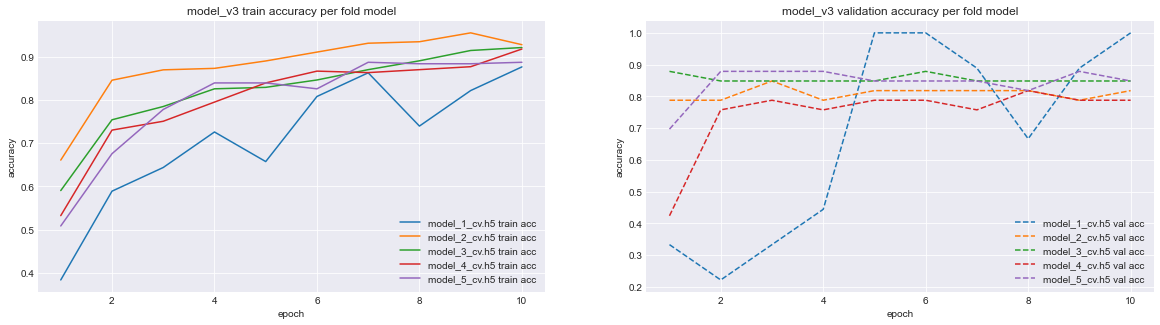

In [387]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
plt.style.use('seaborn-darkgrid')

#train acc per fold
train_acc_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    acc = history.history['accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc)
    train_acc_labels.append(f'{model_name} train acc')

ax1.set_title(f"model_{model_version} train accuracy per fold model");
ax1.set_ylabel('accuracy');
ax1.set_xlabel('epoch');
ax1.legend(train_acc_labels, loc='lower right');


# val acc per fold
val_acc_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax2.plot(epochs, acc, '--')
    val_acc_labels.append(f'{model_name} val acc')


ax2.set_title(f"model_{model_version} validation accuracy per fold model");
ax2.set_ylabel('accuracy');
ax2.set_xlabel('epoch');
ax2.legend(val_acc_labels, loc='lower right');

plt.savefig(f"model_figures/model_{model_version}_accuracy_per_fold.png")

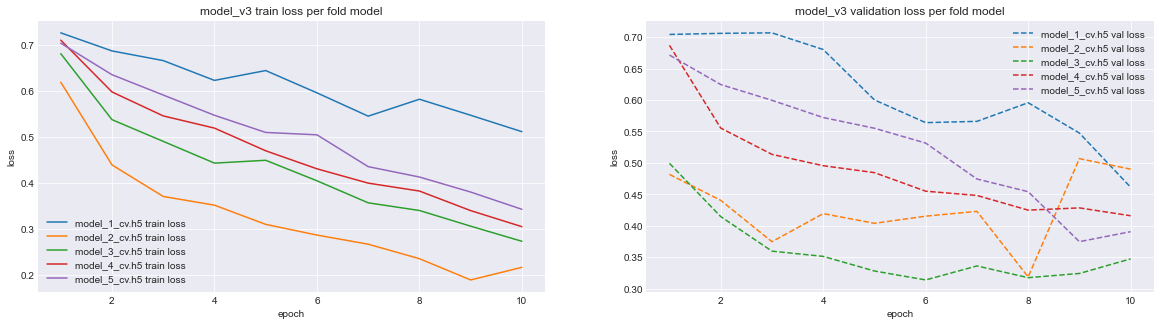

In [386]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
plt.style.use('seaborn-darkgrid')

#plot train loss
train_loss_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    ax1.plot(epochs, loss)
    train_loss_labels.append(f'{model_name} train loss')

ax1.set_title(f"model_{model_version} train loss per fold model");
ax1.set_ylabel('loss');
ax1.set_xlabel('epoch');
ax1.legend(train_loss_labels, loc='lower left');

#plot validation loss
val_loss_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    ax2.plot(epochs, loss, '--')
    val_loss_labels.append(f'{model_name} val loss')

ax2.set_title(f"model_{model_version} validation loss per fold model");
ax2.set_ylabel('loss');
ax2.set_xlabel('epoch');
ax2.legend(val_loss_labels, loc='upper right');

plt.savefig(f"model_figures/model_{model_version}_loss_per_fold.png")

## Comparing Misclassifications on Test Set Across Fold Models

In [458]:
#load in saved fold_indices from kfold split from training
fold_indices = load_fold_indices()

#load in unsplit datasets (we will use X to retrieve name of video)
X, y = load_unsplit_dataset('humpback_whale_videos_with_intervals.csv')

#array to store each y_pred by each model in dataframe 
all_y_pred = []
all_y_true = []
all_test_video_names = []

#arrays to store each models metrics
#we already have test_acc_per_fold, test_loss_per_fold, and histories_per_fold (dict)
accuracy_per_fold_2 = []
confusion_matrix_per_fold_2 = []
precision_per_fold_2 = []
recall_per_fold_2    = []
f1_per_fold_2        = []

for fold_no in range(1, 6):

    #get fold model name and path to weights
    fold_model_name = get_model_name(str(fold_no) + '_cv')
    weights_path    = 'saved_models_v3/' + fold_model_name

    #create rnn model and load weights 
    fold_rnn_model = create_rnn_model()
    fold_rnn_model.load_weights(weights_path) #load in weights

    #get test data for fold
    test_index = fold_indices[fold_model_name][1]
    test_features_fold,  test_masks_fold,  test_labels_fold  = all_frame_features_filled_middle[test_index],  all_frame_masks_filled_middle[test_index],  all_labels_filled_middle[test_index]

    #compile
    fold_rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) 

    #predict
    probabilities = fold_rnn_model.predict([test_features_fold, test_masks_fold])
    y_pred = np.array([np.argmax(p) for p in probabilities])
    y_true = test_labels_fold.flatten()

    #metrics for FOLD MODEL
    fold_test_acc = metrics.accuracy_score(y_true, y_pred)
    print(f'Test Accuracy for fold_no={fold_no}: {fold_test_acc}')

    cm = metrics.confusion_matrix(y_true, y_pred)
    precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred) #precision, recall, f1, and support are obtained for each class [0 1] (ex. precision = [0.92  0.86])

    #save metrics for each fold model
    accuracy_per_fold_2.append(fold_test_acc)
    confusion_matrix_per_fold_2.append(cm)
    precision_per_fold_2.append(precision)
    recall_per_fold_2.append(recall)
    f1_per_fold_2.append(f1)

    #save predictions, truths, and video names in test set used for each fold model
    all_y_pred.append(y_pred)
    all_y_true.append(y_true)
    all_test_video_names.append(list(X.loc[test_index]['renamed_title']))
    

Test Accuracy for fold_no=1: 0.8902439024390244
Test Accuracy for fold_no=2: 0.8780487804878049
Test Accuracy for fold_no=3: 0.8641975308641975
Test Accuracy for fold_no=4: 0.8395061728395061
Test Accuracy for fold_no=5: 0.8148148148148148


Average accuracy when rerun is the exact same :)

In [474]:
all_y_pred_2 =  np.concatenate(all_y_pred).ravel()
all_y_pred_2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [475]:
all_y_true_2 = np.concatenate(all_y_true).ravel()
all_y_true_2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [478]:
all_test_video_names_2 = np.concatenate(all_test_video_names).ravel()
all_test_video_names_2

array(['video_0000.mp4', 'video_0001.mp4', 'video_0016.mp4',
       'video_0023.mp4', 'video_0025.mp4', 'video_0043.mp4',
       'video_0044.mp4', 'video_0048.mp4', 'video_0049.mp4',
       'video_0054.mp4', 'video_0064.mp4', 'video_0065.mp4',
       'video_0066.mp4', 'video_0078.mp4', 'video_0082.mp4',
       'video_0089.mp4', 'video_0092.mp4', 'video_0095.mp4',
       'video_0096.mp4', 'video_0099.mp4', 'video_0101.mp4',
       'video_0105.mp4', 'video_0107.mp4', 'video_0119.mp4',
       'video_0124.mp4', 'video_0131.mp4', 'video_0135.mp4',
       'video_0147.mp4', 'video_0148.mp4', 'video_0503.mp4',
       'video_0505.mp4', 'video_0509.mp4', 'video_0511.mp4',
       'video_0513.mp4', 'video_0515.mp4', 'video_0518.mp4',
       'video_0523.mp4', 'video_0528.mp4', 'video_0537.mp4',
       'video_0541.mp4', 'video_0552.mp4', 'video_0559.mp4',
       'video_0569.mp4', 'video_0570.mp4', 'video_0574.mp4',
       'video_0582.mp4', 'video_0594.mp4', 'video_0595.mp4',
       'video_0597.mp4',

### Make Dataframe of Video Names, True Label, and Predicted Label

In [490]:
test_folds_results  = pd.DataFrame({'video_name': all_test_video_names_2, 
                                    'true': all_y_true_2,
                                    'pred': all_y_pred_2})

## save as csv
# test_folds_results.to_csv(f"model_figures/test_fold_classifications_model_{model_version}.csv")
test_folds_results

,video_name,true,pred
0,video_0000.mp4,1,1
1,video_0001.mp4,1,1
2,video_0016.mp4,1,1
3,video_0023.mp4,1,1
4,video_0025.mp4,1,1
...,...,...,...
402,video_0811.mp4,0,0
403,video_0812.mp4,0,0
404,video_0814.mp4,0,0
405,video_0815.mp4,0,0


In [498]:
#misclassified videos
incorrect_test_fold_classifications = test_folds_results[test_folds_results.true != test_folds_results.pred].copy(deep=True)
incorrect_test_fold_classifications.head()

,video_name,true,pred
20,video_0101.mp4,1,0
21,video_0105.mp4,1,0
24,video_0124.mp4,0,1
26,video_0135.mp4,0,1
33,video_0513.mp4,0,1


In [503]:
false_positives = incorrect_test_fold_classifications[incorrect_test_fold_classifications.pred == 1] #pred = 1, true = 0 (actually irrel, pred rel)
false_negatives = incorrect_test_fold_classifications[incorrect_test_fold_classifications.pred == 0] #pred = 0, true = 1 (actually rel, pred irrel)

print(f'There are {len(false_positives)} False Positives totalled across all 5 fold models')
print(f'There are {len(false_negatives)} False Negatives totalled across all 5 fold models')

There are 42 False Positives totalled across all 5 fold models
There are 16 False Negatives totalled across all 5 fold models


In [524]:
#sort the video names of false positives to make it easier to look thru videos
fp = list(false_positives['video_name'])
fp.sort()

print(fp)
# false_positives

['video_0109.mp4', 'video_0110.mp4', 'video_0115.mp4', 'video_0124.mp4', 'video_0133.mp4', 'video_0135.mp4', 'video_0138.mp4', 'video_0139.mp4', 'video_0140.mp4', 'video_0513.mp4', 'video_0518.mp4', 'video_0531.mp4', 'video_0539.mp4', 'video_0543.mp4', 'video_0545.mp4', 'video_0567.mp4', 'video_0574.mp4', 'video_0576.mp4', 'video_0577.mp4', 'video_0581.mp4', 'video_0584.mp4', 'video_0595.mp4', 'video_0598.mp4', 'video_0600.mp4', 'video_0601.mp4', 'video_0610.mp4', 'video_0618.mp4', 'video_0738.mp4', 'video_0739.mp4', 'video_0740.mp4', 'video_0742.mp4', 'video_0746.mp4', 'video_0747.mp4', 'video_0751.mp4', 'video_0754.mp4', 'video_0756.mp4', 'video_0762.mp4', 'video_0763.mp4', 'video_0765.mp4', 'video_0774.mp4', 'video_0776.mp4', 'video_0810.mp4']


In [526]:
# false_negatives

fn = list(false_negatives['video_name'])
fn.sort()

print(fn)

['video_0012.mp4', 'video_0021.mp4', 'video_0101.mp4', 'video_0105.mp4', 'video_0137.mp4', 'video_0629.mp4', 'video_0658.mp4', 'video_0662.mp4', 'video_0673.mp4', 'video_0695.mp4', 'video_0702.mp4', 'video_0795.mp4', 'video_0801.mp4', 'video_0804.mp4', 'video_0807.mp4', 'video_0809.mp4']


In [530]:
y[y.relevant == True]  #203 relevant videos
y[y.relevant == False] #204 irrelevant videos



,relevant
45,False
100,False
102,False
105,False
108,False
...,...
402,False
403,False
404,False
405,False


# Visualizing Model Architecture

source: https://towardsdatascience.com/neural-network-model-architecture-visualization-3c2fae610330

In [531]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.5/507.5 KB 456.0 kB/s eta 0:00:00
You should consider upgrading via the '/Users/michelleramirez/opt/anaconda3/envs/geo_env_ML/bin/python3.9 -m pip install --upgrade pip' command.


In [566]:
## note: kept getting error so will not be using this as a figure
# import visualkeras

# #setting
# class_vocab          = [0, 1] 
# frame_features_input = keras.Input(shape = (MAX_SEQ_LENGTH, NUM_FEATURES))
# mask_input           = keras.Input(shape = (MAX_SEQ_LENGTH, ), dtype="bool")
# x                    = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
# x                    = keras.layers.GRU(8)(x)
# x                    = keras.layers.Dropout(0.4)(x)
# x                    = keras.layers.Dense(8, activation="relu")(x)
# output               = keras.layers.Dense(2, activation="softmax")(x)

# rnn_model            = keras.Model([frame_features_input, mask_input], output)

# #visualize
# visualkeras.layered_view(rnn_model)

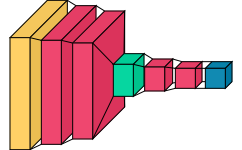

In [534]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling2D(3)(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = keras.layers.GlobalMaxPooling2D()(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
visualkeras.layered_view(encoder)

In [564]:
!pip3 install keras-visualizer
# !conda install -c anaconda python-graphviz